In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.cluster import KMeans
from   sklearn.metrics import silhouette_score
from   sklearn.mixture import GaussianMixture

%matplotlib inline

In [2]:
K = np.random.choice(range(2, 9)) # randomly use 2 to 8 clusters
N_PER = 100

In [3]:
def rand_color():
    digits = list('0123455679ABCDEF')
    return '#' + ''.join(np.random.choice(digits, size=6, replace=True))

In [4]:
def generate_random_params(k):
    HIGH = 10
    SD = 1
    params = []
    for _ in range(k):
        x = np.random.uniform(high=HIGH)
        y = np.random.uniform(high=HIGH)
        cov = np.random.uniform(low=-HIGH / 3, high=HIGH / 3)
        sdx = np.abs(np.random.normal(scale=SD))
        sdy = np.abs(np.random.normal(scale=SD))
        sigma = [[sdx, cov],
                 [cov, sdy]]
        params.append({'x': x, 'y': y, 'sigma': sigma})
    return params

In [5]:
def make_clusters(params, n_per):
    clusters = []
    for k, p in enumerate(params):
        col = rand_color()
        points = np.random.multivariate_normal(
            [p['x'], p['y']], p['sigma'], size=n_per)
        x = points[:, 0]
        y = points[:, 1]
        df = pd.DataFrame(
            {'x': x,
             'y': y,
             'k': [k] * n_per,
             'color': col})
        clusters.append(df)
    return pd.concat(clusters)

In [6]:
def generate_round_params(k):
    HIGH = 10
    SD = 1
    params = [
        {'x': np.random.uniform(high=HIGH),
         'y': np.random.uniform(high=HIGH),
         'sd': np.abs(np.random.normal(scale=SD))}
        for _ in range(k)]
    return params

In [7]:
def make_round_clusters(params, n_per):
    clusters = []
    for k, p in enumerate(params):
        col = rand_color()
        df = pd.DataFrame(
            {'x': np.random.normal(p['x'], scale=p['sd'], size=n_per),
             'y': np.random.normal(p['y'], scale=p['sd'], size=n_per),
             'k': [k] * n_per,
             'color': col})
        clusters.append(df)
    out = pd.concat(clusters)
    out.index = range(out.shape[0])
    return out

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


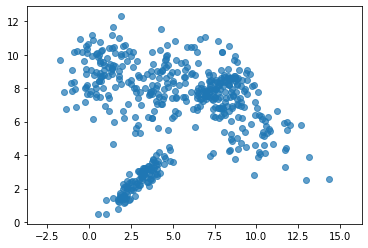

In [37]:
#ROUND = True
ROUND = False

if ROUND:
    params = generate_round_params(K) 
    clust = make_round_clusters(params, N_PER)
else:
    params = generate_random_params(K)
    clust = make_clusters(params, N_PER)

plt.scatter(clust.x, clust.y, alpha=0.7)
plt.axis('equal');

In [38]:
color_map = {k: rand_color() for k in range(10)}

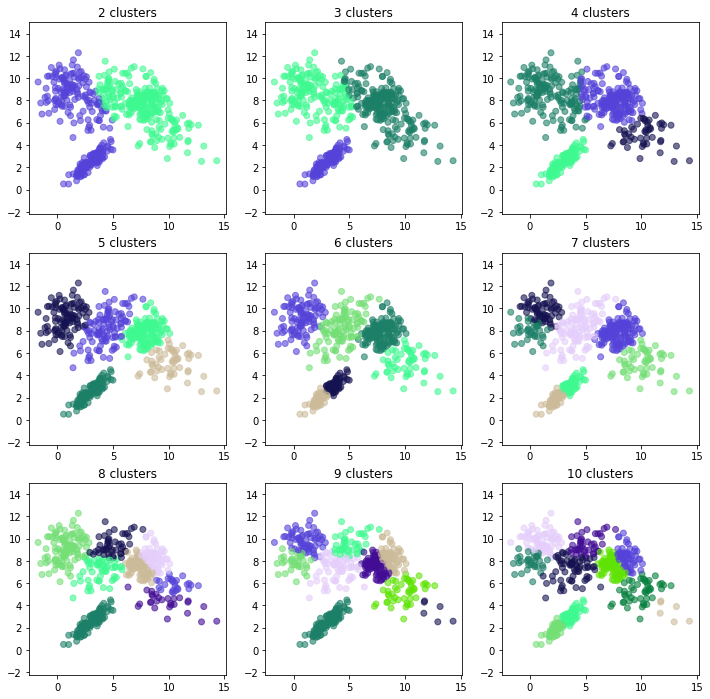

In [39]:
X = clust[['x', 'y']]

plt.figure(figsize=(12, 12))
i = 1
for k in range(2, 11):
    plt.subplot(3, 3, i)
    gmm = GaussianMixture(n_components=k, covariance_type='full')
    gmm.fit(X)
    assignments = gmm.predict(X)
    plt.scatter(clust.x,
                clust.y,
                color=list(map(lambda x: color_map[x], assignments)),
                alpha=0.6)
    plt.axis('equal')
    plt.title(f'{k} clusters')
    i += 1

What do your eyes and intuition tell you?  How many clusters are there?
Now take a look by running the next cell and see how you did.

In [40]:
K

5

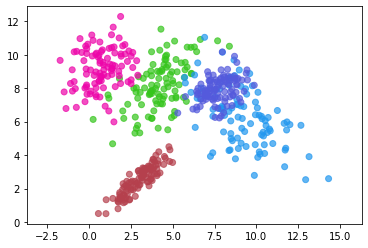

In [41]:
# Ground truth
plt.scatter(clust.x, clust.y, color=clust.color, alpha=0.7)
plt.axis('equal');

In the case of Gaussian Mixture models the EM algorithm is already calculating the Likelihood of the data given the model (as we saw in the R script).  So, it is a very intuitive to convert the likelihood into an information criterion like the Akaike Information Criterion (AIC) or the Bayesian (BIC), which are both functions of the likelihood and the number of parameters in the model (in GMM, the parmaters you are estimating are: the cluster means and either a single value, diagonal values, or all values of the covariance matrix).

$$AIC = 2k - 2ln(\hat L)$$
$$BIC = ln(n)k - 2ln(\hat L)$$

where <i>k</i> is the number of parameters, and <i>L</i>-hat the Likelihood metric, and <i>n</i> the number of data points, and lower values are "better". Which method to prefer is a matter of much debate, and you can read up on it <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion#Comparisons_with_other_model_selection_methods">here</a>, or the references therein.

Frequently, though not always, they will agree on the optimal choice.

In [42]:
aics = []
bics = []
ks = range(1, 11)
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full')
    gmm.fit(X)
    aics.append(gmm.aic(X))
    bics.append(gmm.bic(X))

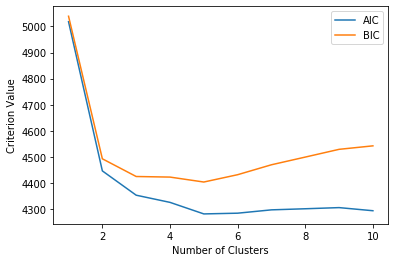

In [43]:
plt.plot(ks, aics, label='AIC')
plt.plot(ks, bics, label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Criterion Value')
plt.legend();

Did either or both match ground truth?  Did either match your intuition?

This method will not work for every clustering method however, as not all methods can be parameterized.  One method used by k-means to determine "goodness of fit" is what they call <i>inertia</i> (also called the <i>within cluster sum of squares</i>):

$$\sum_{i}^n (dist(p_i, k_i))^2$$

where <i>p<sub>i</sub></i> is the <i>ith</i> point, and <i>k<sub>i</sub></i> is the centroid the point is assigned to, and <i>dist</i> could theoretically be any distance metric, but by default is Euclidean distance.

In `sklearn` this value can be obtained from the `inertia_` attribute of the model object:

When K is fixed, this method works well for picking the best initialization, and is how the KMeans method choses among its random initializations:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


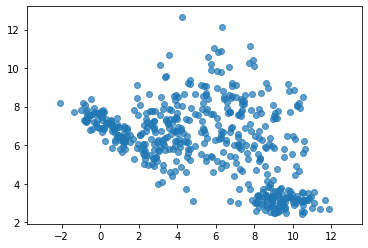

In [44]:
K = 5
N_PER = 100
params = generate_random_params(K)
clust = make_clusters(params, N_PER)

plt.scatter(clust.x, clust.y, alpha=0.7)
plt.axis('equal');

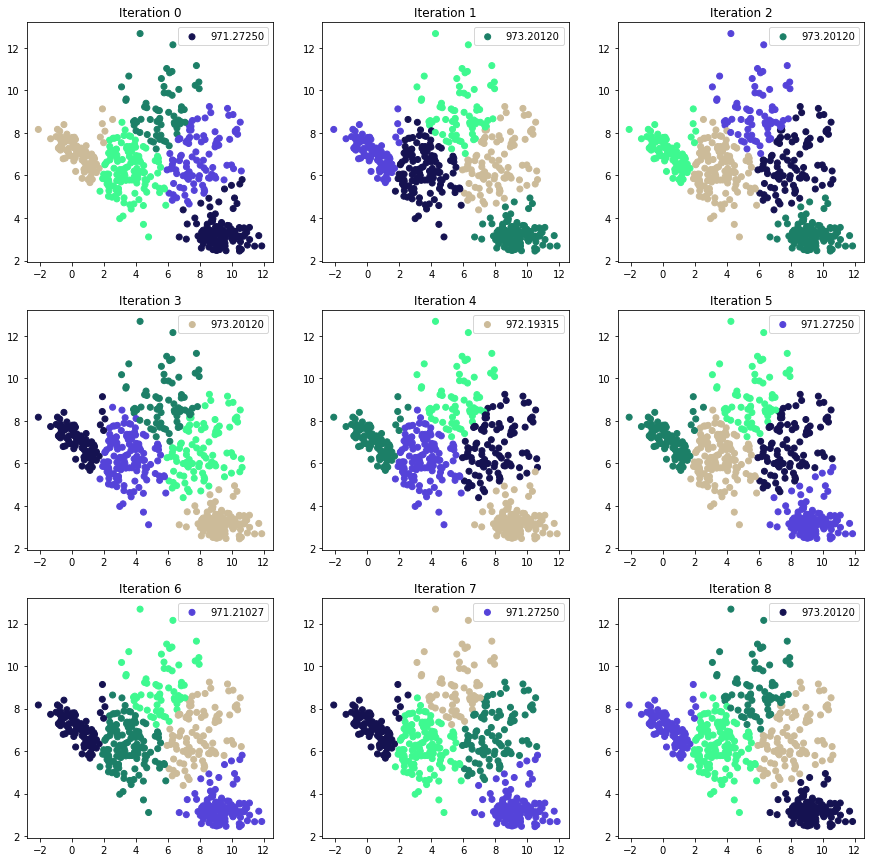

In [45]:
inertias = []
TRIES = 9

X = clust[['x', 'y']]
plt.figure(figsize=(15, 15))
for i in range(TRIES):
    km = KMeans(K, n_init=1)
    km.fit(X)
    assignments = km.predict(X)
    inertia = km.inertia_
    inertias.append(inertia)
    plt.subplot(3, 3, i + 1)
    plt.scatter(clust.x, 
                clust.y, 
                color=list(map(lambda x: color_map[x], assignments)),
                label=f'{inertia:.5f}')
    plt.legend()
    plt.title(f'Iteration {i}')

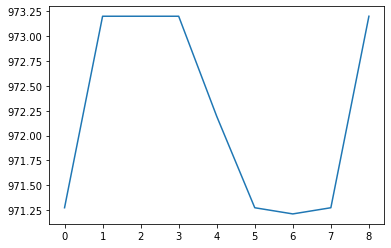

In [46]:
plt.plot(inertias);

However, this method is less ideal for choosing the number of clusters:

In [47]:
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10*k)
    km.fit(X)
    inertias.append(km.inertia_)

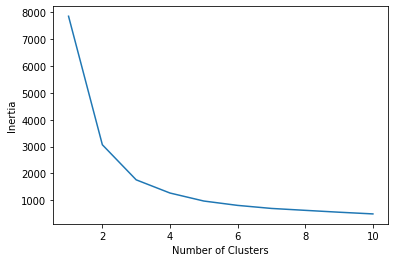

In [48]:
plt.plot(ks, inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

Some people have used this method, with the so-called "elbow" method: at which point doed the decrease in inertia become "negligible", (i.e., the "elbow" in the above graph), but this is somewhat subjective.

Another method is known as the "silhouette" method, where the approach is to measure how similar each point is to the rest of its cluster.

We calculate:
- A measure of similarity with each point and its cluster:
$$a(i) = \frac {1}{|C_i|-1} \sum_{j \in C_i, i ≠ j}dist(i, j)$$

where C<sub>i</sub> is the cluster point <i>i</i> belongs to, and <i>j</i>s are all the other points in the cluster.
|C<sub>i</sub>| is the cardinality of the cluster (number of points), so the intial fraction just serves to normalize the sum of ditances.  That is, the whole value is the average distance between points in the cluster.

- A measure of (dis?)similarity with each point and other clusters:
$$b(i) = min_{i≠j} \frac{1}{|C_j|} \sum_{j \in C_j}dist(i, j)$$

So, for each other cluster, we determine the average distance between our point and the other points in the cluster, and use the cluster that with the minimum value (i.e., the other cluster that is least dissimilar--or most similar--to the cluster it is assigned to).

Finally
- The silhouette value:
$$s(i) = \frac {b(i) - a(i)}{max(a(i), b(i))}$$

Except, if the cardinality of C<sub>i</sub> is 1, then 
$$s(i) = 0$$

So, this value can vary between -1 and +1, with +1 being optimal.  We get values closer to +1 as b(i) becomes large (big distance between each point and other clusters) and a(i) becomes small (small distance between points within the cluster).  

Feel free to code up your own version if you like... here I'll use the `sklearn` version:


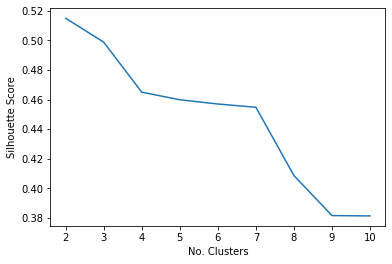

In [49]:
silhouettes = []

ks = range(2, 11)
for k in ks:
    km = KMeans(k, n_init=30).fit(X)
    assignments = km.labels_
    silhouettes.append(
        silhouette_score(X, assignments, metric='euclidean'))
    
plt.plot(ks, silhouettes)
plt.xlabel('No. Clusters')
plt.ylabel('Silhouette Score');

In [50]:
k_opt = silhouettes.index(max(silhouettes)) + 2
k_opt

2

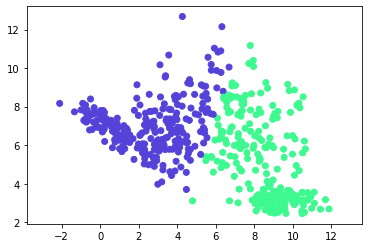

In [51]:
km = KMeans(k_opt).fit(X)
clust['km_opt'] = km.labels_
plt.scatter(
    clust.x, clust.y, color=clust.km_opt.apply(lambda x: color_map[x]))
plt.axis('equal');

In [52]:
K

5

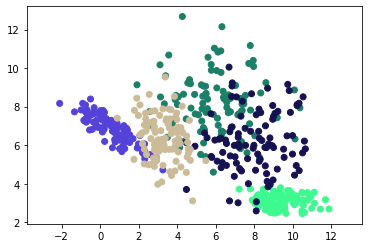

In [53]:
# Ground truth
plt.scatter(
    clust.x, clust.y, color=clust.k.apply(lambda x: color_map[x]))
plt.axis('equal');

Final questions: 
- Is this always a good metric? If not, when would it not be?
- What about scaling our data?  Do we want to do this?  When and why?

Now try setting `ROUND=False` and running again....